In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt



In [2]:
# set up environment
dim = 2
grid_size = {'x': 20, 'y': 20}
domain_size = {'x': 20, 'y': 20}

# boundary_condition
# constant boundary condition
bc_left = 0
bc_right = 0
bc_top = 0
bc_bottom = 0

delta_x = domain_size['x'] / grid_size['x']
delta_y = domain_size['y'] / grid_size['y'] 

alpha_x = np.random.random((grid_size['x'],grid_size['y']))
alpha_y = np.ones((grid_size['x'],grid_size['y']))

time_step = 0.1

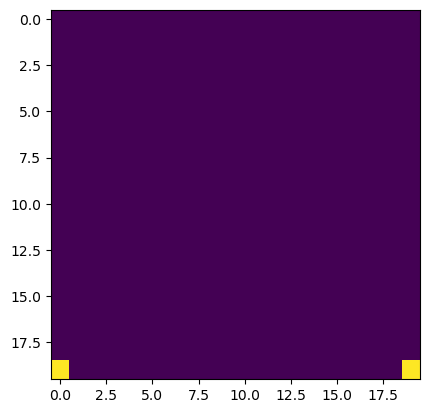

In [3]:
# initialize environment with start values
C_t = np.zeros((grid_size['x'],grid_size['y']))
C_t[19,0] = 2000
C_t[19,19] = 2000


plt.imshow(C_t, vmin=0, vmax=2000)
plt.show()

In [4]:
# calculate mean between two cells
def alpha_interblock(alpha1, alpha2, harmonic=True):
    if not harmonic:
        return 0.5 * (alpha1 + alpha2)
    else:
        return 2 / ((1/alpha1) + (1/alpha2))

In [6]:
def sub(delta_t, delta_x):
    return delta_t / (2 * delta_x**2)